<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#OPTIM-EASE:--Mall-load-profile-generation" data-toc-modified-id="OPTIM-EASE:--Mall-load-profile-generation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>OPTIM-EASE:  Mall load profile generation</a></span><ul class="toc-item"><li><span><a href="#Refrigeration-annual-profile" data-toc-modified-id="Refrigeration-annual-profile-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Refrigeration annual profile</a></span></li><li><span><a href="#Open-/-Close-distribution" data-toc-modified-id="Open-/-Close-distribution-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Open / Close distribution</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Plots</a></span></li><li><span><a href="#Sources" data-toc-modified-id="Sources-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Sources</a></span></li></ul></li></ul></div>

# OPTIM-EASE:  Mall load profile generation

In [75]:
 "General dependencies"
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

Malls represent big energy consumers and potential heat sources for small district heating networks (Flexynets). Inside malls there are two types of shops, food shops that need refrigeration, and other shops. On average food shops represent 20% of the surface of malls (Flexynets). For supermarket the value should be 100%. 

In [2]:
f_food = 0.2

All the consumption values are given with respect to the surface of the mall. To estimate the surface of a mall, a value of 0.3m2/inhab can be taken.

In [3]:
#Global Leasable Area (m2)
S = 20000 
# or S = 0.3 * inhabitants

In [4]:
# Annual energy consumptions (kWh/an) [1][2]
E_fri = 250 * S * f_food
E_light = 125 * S
E_hvac = 100 * S 
E_othr = 25 *S

The consumption can be considered constant during a day. However there is a higher consumption during opening hours. The daily profile (open/closed) is described later. 

In [5]:
# Opening hours (from - to)
am = 8
pm = 20
days = 365

## Refrigeration annual profile

In [6]:
# Refrigeration mean annual power (day/night together) 
P_fri_mean = E_fri / 8760 #kW

P = np.zeros(365)
n = np.linspace(1,365,365)

The refrigeration power depends on the outdoor temperature. An annual profile [3] is used to account for this dependency:
$$ P_{fri}(n) = \overline{P}_{fri}[1-0.22 cos(\frac{2\pi n}{365})]$$ 
Where n is the day of the year and $\overline{P}_{fri}$ is the mean refrigeration power (kW) over a year (day and night together).

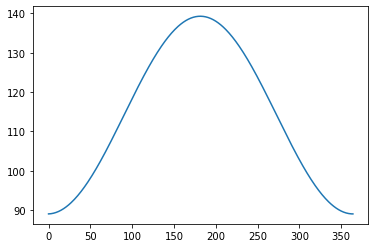

In [7]:
# Annual profile of mean refrigeration power [3]
i = 0
for p in P:
    p = P_fri_mean * ( 1 - 0.22 * math.cos ( 2 * math.pi * n[i] / 365 ))
    P[i] = p
    i += 1

plt.plot(P)

## Open / Close distribution
Close consumptions [4]:


    - Refrigeration : Reduction of 20% during closing hours
    - Hvac: Reduction of 50% of 75% during closing hours
    - Lights: Off
    - Others: Off
   

In [8]:
# 1 year hourly profile based on Flexynets opening hours: 8h/20h 
t_tot = np.linspace(1,8760,8760)
t_fri = np.linspace(1,8760,8760)
t_light = np.linspace(1,8760,8760)
t_hvac = np.linspace(1,8760,8760)
t_othr = np.linspace(1,8760,8760)
heures = np.linspace(1,8760,8760)

i = 0 
k = 0
K = 0
for T in t_tot:
    H = T - k * 24

    # Night / Day
    if H < am or H > pm:
        t_fri[i] = 1.6/1.8 * P[k]                   # kW
        t_light[i] = 0                              # kW
        t_hvac[i] = 37.5/137.5 * E_hvac / (24*days) # kW
        t_othr[i] = 0
        t_tot[i] = t_fri[i] + t_light[i] + t_hvac[i] + t_othr[i]
        
    else:
        t_fri[i] = 2/1.8 * P[k]                     # kW
        t_light[i] = E_light / ((pm-am)*days)       # kW
        t_hvac[i] = 100/137.5 * E_hvac / (24*days)  # kW
        t_othr[i] = E_othr / ((pm-am)*days)
        t_tot[i] = t_fri[i] + t_light[i] + t_hvac[i] + t_othr[i]
    heures[i] = H
    K += 1
    k = int(K // 24)
    i += 1

The annual profile is generated and saved in .csv format at the adress specified here:

In [9]:
filename = "mall_profile.csv"

In [10]:
d = {'heures': heures, 'total': t_tot, 'Refrigeration':t_fri, 'Lighting':t_light, 'HVAC':t_hvac, 'Other':t_othr}
df = pd.DataFrame(data=d)
df.to_csv(filename)

## Plots 

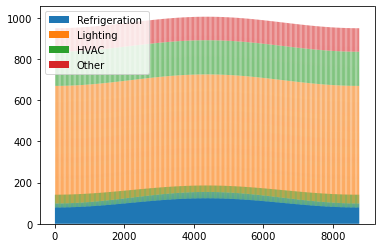

In [11]:
labels = ["Refrigeration ", "Lighting", "HVAC", "Other"]

x = np.linspace(1,8760,8760)

fig, ax = plt.subplots()
ax.stackplot(x, t_fri, t_light, t_hvac, t_othr, labels=labels)
ax.legend(loc='upper left')
plt.show()


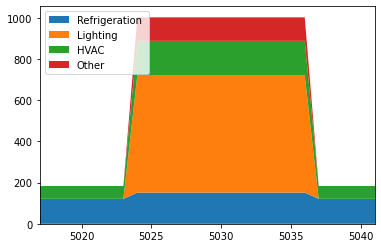

In [12]:
#Plot uniquement une journée typique
start = 5017 # jan (0), jui (~5017), oct(~7300)
end = start + 24

labels = ["Refrigeration ", "Lighting", "HVAC", "Other"]

x = np.linspace(1,8760,8760)

fig, ax = plt.subplots()
ax.stackplot(x, t_fri, t_light, t_hvac, t_othr, labels=labels)
ax.legend(loc='upper left')
plt.xlim([start,end])
plt.show()


## Sources

[1] "Shopping Malls Features in EU-28 + Norway", CommONEnergy, Deliverable 2.1,  2014, p.42, http://r1.zotoi.com/uploads/deliverable/file/1/WP2_D2.1_20141130_P05_Shopping_malls_features_in_EU-28_and_Norway_NP.pdf

[2] "Best environmental Management Practice in the retail trade sector", JRC scientific and policy report, p.14, 2013
https://susproc.jrc.ec.europa.eu/product-bureau/sites/default/files/inline-files/RetailTradeSector_0.pdf

[3] "Integration of substations into HDC networks", D3.2, Flexynets, 2018, p.70,
https://w4u0es9f4.wimuu.com/Download?id=file:54341800&s=7249709264999378256


[4] The profile is estimated by M.Cozzini in an internal Flexynets report from the model presented in: "Best environmental Management Practice in the retail trade sector", JRC scientific and policy report, p.39, 2013
https://susproc.jrc.ec.europa.eu/product-bureau/sites/default/files/inline-files/RetailTradeSector_0.pdf

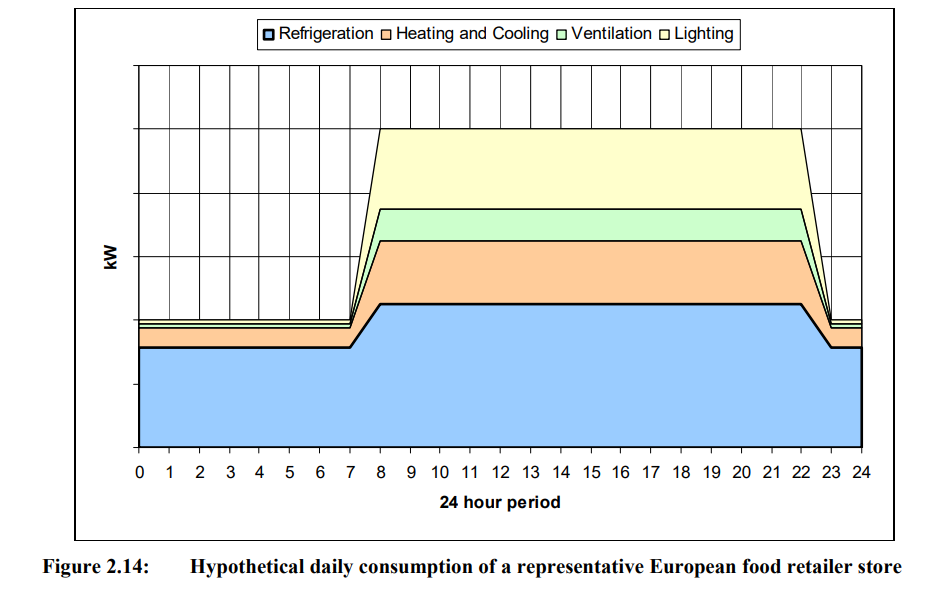

In [1]:
%qtconsole